<a href="https://colab.research.google.com/github/mabeto5p/License_plate/blob/main/license_plate_bounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/license_plate/data/'

Mounted at /content/gdrive


In [127]:
from torch.utils.data import *
from imutils import paths
import cv2
import numpy as np
class labelFpsDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get image name
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)

        # Resize image
        resizedImage = cv2.resize(img, self.img_size)
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0


        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')

        # Find leftUp and rightDown from file-name of original image
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]

        # Find original width and original height of original image
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]

        # Find scale values for width and height
        scale_height, scale_width = self.img_size[1] / ori_h, self.img_size[0] / ori_w

        scales = (scale_width, scale_height, self.img_size[1], ori_h, self.img_size[0], ori_w)

        scaled_leftUp = (int(leftUp[0] * scale_width), int(leftUp[1] * scale_height))
        scaled_rightDown = (int(rightDown[0] * scale_width), int(rightDown[1] * scale_height))

        # All four values of leftUp and rightDown scaled in 1 vector
        scaled_labels = (scaled_leftUp, scaled_rightDown)
        # scaled_labels = [int(leftUp[0] * scale_x, leftUp[1] * scale_y), (rightDown[0] * scale_x, rightDown[1] * scale_y)]

        original_labels = (leftUp, rightDown)
        # Flatten scaled_labels into a 1D list
        flattened_labels = [coordinate for point in scaled_labels for coordinate in point]

        # Convert the 1D list to a tensor and reshape it to (1, 4)
        scaled_labels_tensor = torch.tensor(flattened_labels, dtype=torch.float32)


        return resizedImage, scaled_labels_tensor, img_name, original_labels, scales #lbl, img_name

data_loader = labelFpsDataLoader([data_path],(500,1000))
trainloader = DataLoader(data_loader, batch_size=2, shuffle=False, num_workers=1)

In [148]:
from google.colab.patches import cv2_imshow
import torch

data_loader = labelFpsDataLoader([data_path],(500,1000))
trainloader = DataLoader(data_loader, batch_size=10, shuffle=False, num_workers=1)

trainloader_iter = iter(trainloader)

# Get a single batch from the DataLoader
batch = next(trainloader_iter)


tensor([198., 457., 250., 481.])


Text(0.5, 1.0, 'Scaled image')

<Figure size 640x480 with 0 Axes>

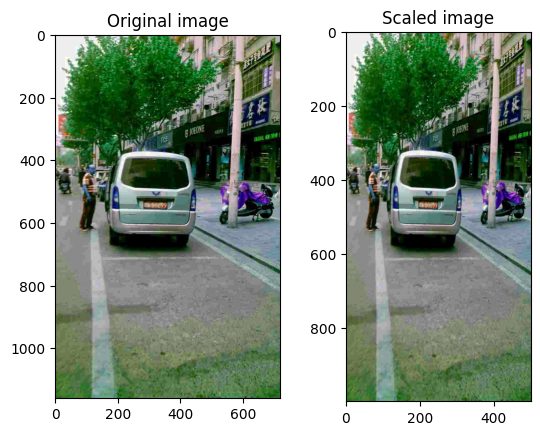

In [129]:
#Plot both the scaled and the original image
some_img = cv2.imread(batch[2][0])
image = batch[0][0]

scaledLabels = batch[1][0]
print(scaledLabels )


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread(batch[2][0]))
axarr[0].set_title("Original image")
axarr[1].imshow(image)
axarr[1].set_title("Scaled image")

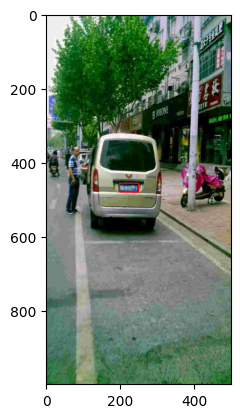

In [149]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

numpy_array = image.cpu().detach().numpy()
cv2_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)

def plot_img_and_boundingbox(resized_img, labels):
    # Extract numerical values from tensors and convert to integers
    leftUp = (int(labels[0]),int(labels[1]))
    rightDown = (int(labels[2]),int(labels[3]))
    # Draw rectangle on the image
    new_image = cv2.rectangle(resized_img, leftUp, rightDown, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.show()

scaled_labels = batch[1][0]

plot_img_and_boundingbox(cv2_image, scaled_labels)

In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


from typing import Union



In [151]:
import keras.utils as image_utils

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np



In [152]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [154]:
import torch.nn as nn
net = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Linear(1024, out_features=4, bias=True),
)
model.classifier = net

In [155]:
#Sets model to training mode,e this is important for layers that have different functionalities depending on training or eval. for example BatchNorm
model.train()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [156]:
layers_of_classifier = 4
for i, param in enumerate(model.parameters()):
    if i < len(list(model.parameters())) - layers_of_classifier:
        param.requires_grad = False
    else:
        param.requires_grad = True

number_of_layers = len(list(enumerate(model.parameters())))
print(f"Total number of layers is {number_of_layers}")
print(f"Number of pretrained base layers is {number_of_layers - layers_of_classifier}")

Total number of layers is 160
Number of pretrained base layers is 156


In [157]:
def check_requires_grad():
  for name, param in model.named_parameters(): # Just to check
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')

# check_requires_grad()

using device:  cuda


  0%|          | 0/30 [00:00<?, ?it/s]

epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1, In-sample Loss: 14621.5384
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2, In-sample Loss: 5436.7367
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3, In-sample Loss: 2374.3101
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4, In-sample Loss: 1367.3128
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5, In-sample Loss: 2799.6455
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6, In-sample Loss: 1291.3691
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7, In-sample Loss: 1482.9169
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8, In-sample Loss: 3249.6136
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9, In-sample Loss: 5340.9416
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10, In-sample Loss: 5580.3140
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11, In-sample Loss: 2358.9486
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12, In-sample Loss: 1862.5290
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13, In-sample Loss: 6324.2060
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14, In-sample Loss: 6309.2900
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15, In-sample Loss: 2949.2334
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16, In-sample Loss: 1052.3355
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17, In-sample Loss: 1209.6790
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18, In-sample Loss: 1741.4552
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19, In-sample Loss: 1641.4657
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20, In-sample Loss: 1255.8023
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21, In-sample Loss: 959.1799
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22, In-sample Loss: 862.3709
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23, In-sample Loss: 1001.6200
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24, In-sample Loss: 1293.9691
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25, In-sample Loss: 1613.9853
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26, In-sample Loss: 1834.7920
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27, In-sample Loss: 1803.8073
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28, In-sample Loss: 1393.3909
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29, In-sample Loss: 874.9366
epoch


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30, In-sample Loss: 1759.0906


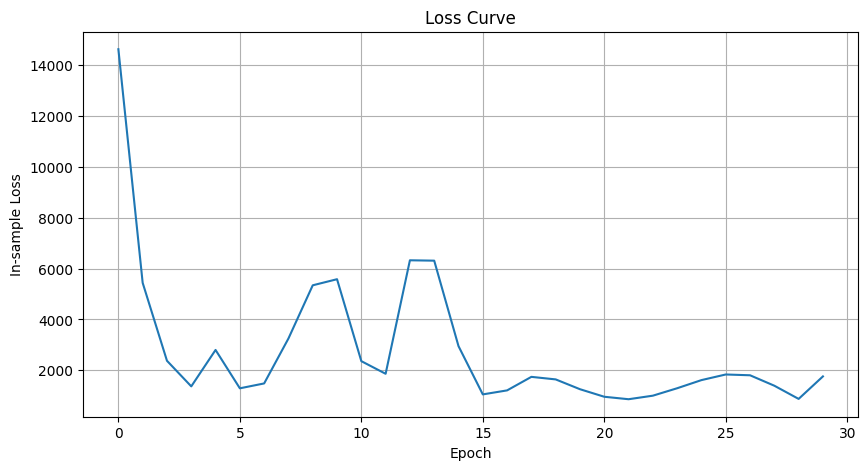

In [158]:
import torch.optim as optim
from tqdm.notebook import tqdm
subset = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
data_loader = labelFpsDataLoader([data_path],(500,1000))
subset = Subset(data_loader, indices=range(30))
trainloader = DataLoader(data_loader, batch_size=4, shuffle=False, num_workers=1)
if subset:
  trainloader =DataLoader(subset, batch_size=4, shuffle=False, num_workers=1)
n_epochs = 30
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.1)
model.train()
model.to(device)
history = []
for epoch in tqdm(range(n_epochs)):
  print("epoch")
  for X_batch_, y_batch, img_name, original_labels, scales in tqdm(trainloader):
    X_batch = X_batch_.permute(0,3,1,2).to(device) #Needs to have shape [batch_size, channels, height, width]
    y_batch = y_batch.to(device)
    y_pred = model(X_batch)
    # print(y_pred.shape)
    # print(y_batch.shape)
    loss = loss_fn(y_pred,y_batch)
    # print(y_pred, y_batch)
    # print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # In-sample loss calculation
  model.eval()  # Switch to evaluation mode to disable features like dropout
  with torch.no_grad():  # Disable gradient calculation to save memory
      total_loss = 0
      total_samples = 0
      for X_batch_, y_batch, img_name, original_labels, scales in trainloader:
          X_batch = X_batch_.permute(0,3,1,2).to(device)
          y_batch = y_batch.to(device)
          y_pred = model(X_batch)

          loss = loss_fn(y_pred, y_batch)
          # print(y_pred, y_batch)
          # print(loss.item())
          total_loss += loss.item() * len(y_batch)  # Accumulate scaled loss
          total_samples += len(y_batch)  # Accumulate number of samples
      insample_loss = total_loss / total_samples  # Calculate average loss
      history.append(insample_loss)
      print(f'Epoch {epoch+1}, In-sample Loss: {insample_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('In-sample Loss')
plt.grid(True)
plt.show()
# model.eval()
# y_pred = model(X_test)
# acc = (y_pred.round() == y_test).float().mean
# acc = float(acc)
# print("Model accuracy: %.2f%%" % (acc*100))

In [159]:
train_image1 = image_numpy[0]
train_image1 = np.expand_dims(train_image1, axis=0)
predicted_box = model.predict(train_image1)
predicted_box = predicted_box.astype(int)
plot_img_and_boundingbox(image_numpy[0], predicted_box[0])

val_image1 = validation_images_numpy[0]
val_image1 = np.expand_dims(val_image1, axis=0)
predicted_box = model.predict(val_image1)
predicted_box = predicted_box.astype(int)

plot_img_and_boundingbox(validation_images_numpy[0], predicted_box[0])

NameError: ignored